## Time series estimation - Contemporary, daily at system level

% TODO: Check if R-squared are correctly computed

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import plotly.plotly
import plotly.tools as tls
import plotly.graph_objs as go

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import numpy as np
import datetime as dt
import time

In [3]:
import statsmodels.api as sm

C:\Users\leoca_000\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [4]:
from Utils import TransantiagoConstants

In [5]:
DTPMDir = TransantiagoConstants.DTPMDir
DTPM_TRXDir = TransantiagoConstants.DTPM_TRXDir

In [6]:
daily_input_path = os.path.join(DTPM_TRXDir,'3_DAILY/daily_summary.csv')
daily_trx = pd.read_csv(daily_input_path,sep=';',encoding='latin-1', index_col=0)

### DAILY AT SYSTEM LEVEL. CREATING NEW DEPENDENT AND INDEPENDENT VARIABLES

In [7]:
daily_trx.loc[:,'TOTAL_trx'] = daily_trx.loc[:,'pn_SUM_TRX_no_t'] + daily_trx.loc[:,'pn_SUM_TRX_3t'] + daily_trx.loc[:,'pn_SUM_TRX_tm'] + daily_trx.loc[:,'zp_SUM_TRX']

In [8]:
independent_variables_path = os.path.join(DTPM_TRXDir,'0_INDEPENDENTS/independents_variables.csv')
independent_variables = pd.read_csv(independent_variables_path,sep=';',encoding='latin-1', index_col=0, parse_dates=[1])

In [9]:
independent_variables.loc[:,'Verano'] =  independent_variables.loc[:,'Enero'] + independent_variables.loc[:,'Febrero']
independent_variables.loc[:,'Nov_Dic_2017'] = independent_variables.loc[:,'Nov_2017'] + independent_variables.loc[:,'Dic_2017']
independent_variables.loc[:,'WEEK_OF_YEAR'] = independent_variables.loc[:,'DATE'].apply(lambda x: x.week)
independent_variables = pd.get_dummies(independent_variables, columns=['WEEK_OF_YEAR'])

In [10]:
complete_db = daily_trx.merge(independent_variables, on =['YEAR','MONTH','YEAR_DAY'], how='left')

In [11]:
complete_db.sort_values(by=['YEAR','MONTH','YEAR_DAY'], ascending=[True,True,True], inplace=True)

### DESCRIPTIVES

* General

In [12]:
descriptives = pd.DataFrame()

In [13]:
descriptives = complete_db.loc[:,'TOTAL_trx'].describe().to_frame('total_trx')
descriptives = pd.concat([descriptives, complete_db.loc[:,'pn_SUM_TRX_no_t'].describe().to_frame()], axis=1, join='inner')
descriptives = pd.concat([descriptives, complete_db.loc[:,'pn_SUM_TRX_3t'].describe().to_frame()], axis=1, join='inner')
descriptives = pd.concat([descriptives, complete_db.loc[:,'pn_SUM_TRX_tm'].describe().to_frame()], axis=1, join='inner')
descriptives = pd.concat([descriptives, complete_db.loc[:,'zp_SUM_TRX'].describe().to_frame()], axis=1, join='inner')

In [14]:
#pd.set_option('display.float_format', '{:.3e}'.format)

In [15]:
#print(descriptives.to_latex())

* Plotting by year

In [16]:
grouped_by_year = complete_db.groupby(['YEAR'])['TOTAL_trx','pn_SUM_TRX_no_t','pn_SUM_TRX_3t','pn_SUM_TRX_tm','zp_SUM_TRX'].sum()

In [17]:
grouped_by_year

,TOTAL_trx,pn_SUM_TRX_no_t,pn_SUM_TRX_3t,pn_SUM_TRX_tm,zp_SUM_TRX
YEAR,,,,,
2015,914266353.0,681051074,138508996,1050625.0,93655658
2016,873690623.0,643134397,129177128,11239945.0,90139153
2017,860265821.0,511644071,107372896,139383299.0,101865555


In [18]:
colors = [(76, 181, 245),(183, 184, 182),(52, 103, 92),(179, 193, 0)]
for i in range(len(colors)):
    r, g, b = colors[i]  
    colors[i] = (r / 255., g / 255., b / 255.)

In [19]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x*1e-6)

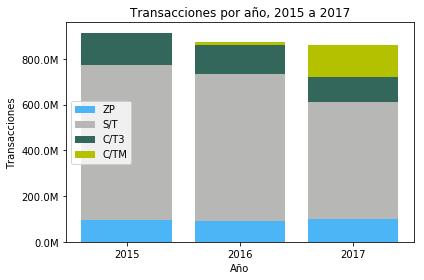

In [20]:
year_values = grouped_by_year.index.values
no_turnstile_values = list(map(int, grouped_by_year['pn_SUM_TRX_no_t'].values))
three_turnstile_values = list(map(int,grouped_by_year['pn_SUM_TRX_3t'].values))
butterfly_turnstile_values = list(map(int,grouped_by_year['pn_SUM_TRX_tm'].values))
zp_values = list(map(int,grouped_by_year['zp_SUM_TRX'].values))
    
formatter = FuncFormatter(millions)
    
labels = ["ZP", "S/T", "C/T3", "C/TM"]
fig, ax = plt.subplots()

p1 = plt.bar(year_values, zp_values, color = colors[0], label='ZP')
p2 = plt.bar(year_values, no_turnstile_values, bottom=zp_values, color = colors[1], label='S/T')
p3 = plt.bar(year_values, three_turnstile_values, bottom= [sum(x) for x in zip(zp_values, no_turnstile_values)], color = colors[2],label='C/T3')
p4 = plt.bar(year_values, butterfly_turnstile_values, bottom= [sum(x) for x in zip(zp_values, no_turnstile_values,three_turnstile_values)], color = colors[3], label='C/TM')

ax.legend()
ax.set_title('Transacciones por año, 2015 a 2017')
ax.set_ylabel('Transacciones')
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Año')
#fig.autofmt_xdate()
plt.xticks(np.arange(min(year_values), max(year_values)+1, 1.0))
plt.tight_layout()
#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/6_trxOverTimeByYear_all.pdf')
        
#plt.show()

### Summary of results: OLS_Summary

In [21]:
OLS_Summary = pd.DataFrame()

In [22]:
def summarizingResults(x, df, model_name):
    params = x.params.rename('params_' + model_name)
    t = x.tvalues.rename('t_' + model_name)
    p = x.pvalues.rename('p_' + model_name)

    df = pd.concat([df, params, t, p], axis=1)
    df.loc['R2_ADJ', 'params_' + model_name] = x.rsquared_adj
    df.loc['AIC', 'params_' + model_name] = x.aic
    df.loc['F', 'params_' + model_name] = x.fvalue
    df.loc['P_F', 'params_' + model_name] = x.f_pvalue
    df.loc['D_W', 'params_' + model_name] = sm.stats.stattools.durbin_watson(x.resid)
    
    return df

#### ESTIMATION. 1ST MODEL

Estimado por OLS.<br>
<strong>Y:</strong><br>
'total de transacciones'<br>
<strong>X:</strong><br>
'SATURDAY',<br>
'SUNDAY',<br>
'ratio_tm',<br>
'kms_ofertados',<br>
'Verano',<br>
'Julio',<br>
'Nov_Dic_2017',<br>
't',<br>
'Feriado_laboral',<br>
'Feriado_no_laboral',<br>
'Censo',<br>
'Elecciones',<br>
'Partido',<br>
'FDS_Largo',<br>
'Disturbios',<br>
'Bucle',<br>
'Clima',<br>
'visperas_laborales', <br>
'N_ZPs'

In [23]:
Y = complete_db.loc[:,'TOTAL_trx']
X = complete_db.loc[:,['SATURDAY',
                       'SUNDAY',
                       'ratio_tm',
                       'kms_ofertados',
                       'Verano',
                       'Julio',
                       'Nov_Dic_2017',
                       't',
                       'Feriado_laboral',
                       'Feriado_no_laboral',
                       'Censo',
                       'Elecciones',
                       'Partido',
                       'FDS_Largo',
                       'Disturbios',
                       'Bucle',
                       'Clima',
                       'visperas_laborales',
                       'N_ZPs']]

In [24]:
X = sm.add_constant(X)
m1 = sm.OLS(Y, X)
results_m1 = m1.fit()
#print(results_m1.summary())

In [25]:
OLS_Summary = summarizingResults(results_m1, OLS_Summary, 'm1')

In [26]:
ypred_m1 = results_m1.predict(X)
complete_db.loc[:,'ypred_m1'] = ypred_m1

----------------

#### ESTIMATION. 2ND MODEL

Estimado por OLS.<br>
<strong>Y:</strong><br>
'total de transacciones'<br>
<strong>X:</strong><br>
'SATURDAY',<br>
'SUNDAY',<br>
'ratio_tm',<br>
'kms_ofertados',<br>
'Verano',<br>
'Julio',<br>
'Nov_Dic_2017',<br>
't',<br>
'Feriado_laboral',<br>
'Feriado_no_laboral',<br>
'Censo',<br>
'Partido',<br>
'FDS_Largo',<br>
'Disturbios',<br>
'Bucle',<br>
'Clima',<br>
'visperas_laborales', <br>
'N_ZPs'<br>
<strong>Omitidas:</strong><br>
'Elecciones'<br>

In [27]:
Y = complete_db.loc[:,'TOTAL_trx']
X = complete_db.loc[:,['SATURDAY',
                       'SUNDAY',
                       'ratio_tm',
                       'kms_ofertados',
                       'Verano',
                       'Julio',
                       'Nov_Dic_2017',
                       't',
                       'Feriado_laboral',
                       'Feriado_no_laboral',
                       'Censo',
                       'Partido',
                       'FDS_Largo',
                       'Disturbios',
                       'Bucle',
                       'Clima',
                       'visperas_laborales',
                       'N_ZPs']]

In [28]:
X = sm.add_constant(X)
m2 = sm.OLS(Y, X)
results_m2 = m2.fit()
#print(results_m2.summary())

In [29]:
OLS_Summary = summarizingResults(results_m2, OLS_Summary, 'm2')

In [30]:
ypred_m2 = results_m2.predict(X)
complete_db.loc[:,'ypred_m2'] = ypred_m2

----------------

#### ESTIMATION. 3RD MODEL

Estimado por OLS.<br>
<strong>Y:</strong><br>
'total de transacciones'<br>
<strong>X:</strong><br>
'SATURDAY',<br>
'SUNDAY',<br>
'ratio_tm',<br>
'kms_ofertados',<br>
'Verano',<br>
'Julio',<br>
't',<br>
'Feriado_laboral',<br>
'Feriado_no_laboral',<br>
'Censo',<br>
'Partido',<br>
'FDS_Largo',<br>
'Disturbios',<br>
'Bucle',<br>
'Clima',<br>
'visperas_laborales', <br>
'N_ZPs'<br>
<strong>Omitidas:</strong><br>
'Elecciones',<br>
'Nov_Dic_2017'

In [31]:
Y = complete_db.loc[:,'TOTAL_trx']
X = complete_db.loc[:,['SATURDAY',
                       'SUNDAY',
                       'ratio_tm',
                       'kms_ofertados',
                       'Verano',
                       'Julio',
                       't',
                       'Feriado_laboral',
                       'Feriado_no_laboral',
                       'Censo',
                       'Partido',
                       'FDS_Largo',
                       'Disturbios',
                       'Bucle',
                       'Clima',
                       'visperas_laborales',
                       'N_ZPs']]

In [32]:
X = sm.add_constant(X)
m3 = sm.OLS(Y, X)
results_m3 = m3.fit()
#print(results_m3.summary())

In [33]:
OLS_Summary = summarizingResults(results_m3, OLS_Summary, 'm3')

In [34]:
ypred_m3 = results_m3.predict(X)
complete_db.loc[:,'ypred_m3'] = ypred_m3

-------------------------------

#### ESTIMATION. 4TH MODEL

Estimado por OLS.<br>
<strong>Y:</strong><br>
'total de transacciones'<br>
<strong>X:</strong><br>
'SATURDAY',<br>
'SUNDAY',<br>
'ratio_tm',<br>
'kms_ofertados',<br>
'Verano',<br>
'Julio',<br>
't',<br>
'Feriado_laboral',<br>
'Feriado_no_laboral',<br>
'Censo',<br>
'Partido',<br>
'FDS_Largo',<br>
'Disturbios',<br>
'Clima',<br>
'visperas_laborales', <br>
'N_ZPs'<br>
<strong>Omitidas:</strong><br>
'Elecciones',<br>
'Nov_Dic_2017',<br>
'Bucle'

In [35]:
Y = complete_db.loc[:,'TOTAL_trx']
X = complete_db.loc[:,['SATURDAY',
                       'SUNDAY',
                       'ratio_tm',
                       'kms_ofertados',
                       'Verano',
                       'Julio',
                       't',
                       'Feriado_laboral',
                       'Feriado_no_laboral',
                       'Censo',
                       'Partido',
                       'FDS_Largo',
                       'Disturbios',
                       'Clima',
                       'visperas_laborales',
                       'N_ZPs']]

In [36]:
X = sm.add_constant(X)
m4 = sm.OLS(Y, X)
results_m4 = m4.fit()
#print(results_m4.summary())

In [37]:
OLS_Summary = summarizingResults(results_m4, OLS_Summary, 'm4')

In [38]:
ypred_m4 = results_m4.predict(X)
complete_db.loc[:,'ypred_m4'] = ypred_m4

---------------

#### ESTIMATION. 5TH MODEL <- <font color='green'> base model </font>

Estimado por OLS.<br>
<strong>Y:</strong><br>
'total de transacciones'<br>
<strong>X:</strong><br>
'SATURDAY',<br>
'SUNDAY',<br>
'ratio_tm',<br>
'kms_ofertados',<br>
'Verano 52, 53, 1, 2, 3, 4, 5, 6, 7, 8, 9',<br>
'Julio',<br>
't',<br>
'Feriado_laboral',<br>
'Feriado_no_laboral',<br>
'FDS_Largo',<br>
'Disturbios',<br>
'Clima',<br>
'Partido',<br>
'Censo',<br>
'visperas_laborales',<br>
'N_ZPs'<br>
<strong>Omitidas:</strong><br>
'Elecciones',<br>
'Nov_Dic_2017',<br>
'Bucle',<br>

In [39]:
Y = complete_db.loc[:,'TOTAL_trx']
X = complete_db.loc[:,['SATURDAY',
                        'SUNDAY',
                        'ratio_tm',
                        'kms_ofertados',
                        'WEEK_OF_YEAR_52',
                        'WEEK_OF_YEAR_53',
                        'WEEK_OF_YEAR_1',
                        'WEEK_OF_YEAR_2',
                        'WEEK_OF_YEAR_3',
                        'WEEK_OF_YEAR_4',
                        'WEEK_OF_YEAR_5',
                        'WEEK_OF_YEAR_6',
                        'WEEK_OF_YEAR_7',
                        'WEEK_OF_YEAR_8',
                        'WEEK_OF_YEAR_9',
                        'Julio',
                        't',
                        'Feriado_laboral',
                        'Feriado_no_laboral',
                        'FDS_Largo',
                        'Disturbios',
                        'Clima',
                        'Partido',
                        'Censo',
                        'visperas_laborales',
                        'N_ZPs']]

In [40]:
X = sm.add_constant(X)
m5 = sm.OLS(Y, X)
results_m5 = m5.fit()
#print(results_m5.summary())

In [41]:
OLS_Summary = summarizingResults(results_m5, OLS_Summary, 'm5')

In [42]:
ypred_m5 = results_m5.predict(X)
complete_db.loc[:,'ypred_m5'] = ypred_m5

-----------------------------

#### ESTIMATION. 6TH MODEL

Estimado por OLS.<br>
<strong>Y:</strong><br>
'total de transacciones'<br>
<strong>X:</strong><br>
'SATURDAY',<br>
'SUNDAY',<br>
'ratio_tm',<br>
'ratio_tm_2',<br>
'kms_ofertados',<br>
'Verano 52, 53, 1, 2, 3, 4, 5, 6, 7, 8, 9',<br>
'Julio',<br>
't',<br>
'Feriado_laboral',<br>
'Feriado_no_laboral',<br>
'FDS_Largo',<br>
'Disturbios',<br>
'Clima',<br>
'Partido',<br>
'Censo',<br>
'visperas_laborales',<br>
'N_ZPs'<br>
<strong>Omitidas:</strong><br>
'Elecciones',<br>
'Nov_Dic_2017',<br>
'Bucle',<br>

In [43]:
complete_db.loc[:,'ratio_tm_2'] = complete_db.loc[:,'ratio_tm']*complete_db.loc[:,'ratio_tm']

In [44]:
Y = complete_db.loc[:,'TOTAL_trx']
X = complete_db.loc[:,['SATURDAY',
                        'SUNDAY',
                        'ratio_tm',
                        'ratio_tm_2',
                        'kms_ofertados',
                        'WEEK_OF_YEAR_52',
                        'WEEK_OF_YEAR_53',
                        'WEEK_OF_YEAR_1',
                        'WEEK_OF_YEAR_2',
                        'WEEK_OF_YEAR_3',
                        'WEEK_OF_YEAR_4',
                        'WEEK_OF_YEAR_5',
                        'WEEK_OF_YEAR_6',
                        'WEEK_OF_YEAR_7',
                        'WEEK_OF_YEAR_8',
                        'WEEK_OF_YEAR_9',
                        'Julio',
                        't',
                        'Feriado_laboral',
                        'Feriado_no_laboral',
                        'FDS_Largo',
                        'Disturbios',
                        'Clima',
                        'Partido',
                        'Censo',
                        'visperas_laborales',
                        'N_ZPs']]

In [45]:
X = sm.add_constant(X)
m6 = sm.OLS(Y, X)
results_m6 = m6.fit()
#print(results_m6.summary())

In [46]:
OLS_Summary = summarizingResults(results_m6, OLS_Summary, 'm6')

In [47]:
ypred_m6 = results_m6.predict(X)
complete_db.loc[:,'ypred_m6'] = ypred_m6

-------------------

#### ESTIMATION. 7TH MODEL

Estimado por OLS.<br>
<strong>Y:</strong><br>
'total de transacciones'<br>
<strong>X:</strong><br>
'SATURDAY',<br>
'SUNDAY',<br>
'ratio_tm_2',<br>
'kms_ofertados',<br>
'Verano 52, 53, 1, 2, 3, 4, 5, 6, 7, 8, 9',<br>
'Julio',<br>
't',<br>
'Feriado_laboral',<br>
'Feriado_no_laboral',<br>
'FDS_Largo',<br>
'Disturbios',<br>
'Clima',<br>
'Partido',<br>
'Censo',<br>
'visperas_laborales',<br>
'N_ZPs'<br>
<strong>Omitidas:</strong><br>
'Elecciones',<br>
'Nov_Dic_2017',<br>
'Bucle',<br>
'ratio_tm'

In [48]:
Y = complete_db.loc[:,'TOTAL_trx']
X = complete_db.loc[:,['SATURDAY',
                        'SUNDAY',
                        'ratio_tm_2',
                        'kms_ofertados',
                        'WEEK_OF_YEAR_52',
                        'WEEK_OF_YEAR_53',
                        'WEEK_OF_YEAR_1',
                        'WEEK_OF_YEAR_2',
                        'WEEK_OF_YEAR_3',
                        'WEEK_OF_YEAR_4',
                        'WEEK_OF_YEAR_5',
                        'WEEK_OF_YEAR_6',
                        'WEEK_OF_YEAR_7',
                        'WEEK_OF_YEAR_8',
                        'WEEK_OF_YEAR_9',
                        'Julio',
                        't',
                        'Feriado_laboral',
                        'Feriado_no_laboral',
                        'FDS_Largo',
                        'Disturbios',
                        'Clima',
                        'Partido',
                        'Censo',
                        'visperas_laborales',
                        'N_ZPs']]

In [49]:
X = sm.add_constant(X)
m7 = sm.OLS(Y, X)
results_m7 = m7.fit()
#print(results_m7.summary())

In [50]:
OLS_Summary = summarizingResults(results_m7, OLS_Summary, 'm7')

In [51]:
ypred_m7 = results_m7.predict(X)
complete_db.loc[:,'ypred_m7'] = ypred_m7

----------------------------

#### ESTIMATION. 8TH MODEL

Estimado por OLS.<br>
<strong>Y:</strong><br>
'total de transacciones'<br>
<strong>X:</strong><br>
'SATURDAY',<br>
'SUNDAY',<br>
'ratio_tm',<br>
'r_tm_x_rtm_18'<br>
'kms_ofertados',<br>
'Verano 52, 53, 1, 2, 3, 4, 5, 6, 7, 8, 9',<br>
'Julio',<br>
't',<br>
'Feriado_laboral',<br>
'Feriado_no_laboral',<br>
'FDS_Largo',<br>
'Disturbios',<br>
'Clima',<br>
'Partido',<br>
'Censo',<br>
'visperas_laborales',<br>
'N_ZPs'<br>
<strong>Omitidas:</strong><br>
'Elecciones',<br>
'Nov_Dic_2017',<br>
'Bucle',<br>
'ratio_tm_2'

In [52]:
complete_db.loc[:,'rtm_17'] = np.where((17<=complete_db.loc[:,'ratio_tm']),1,0)
complete_db.loc[:,'rtm_18'] = np.where((18<=complete_db.loc[:,'ratio_tm']),1,0)

complete_db.loc[:,'r_tm_x_rtm_17'] = complete_db.loc[:,'ratio_tm'] * complete_db.loc[:,'rtm_17']
complete_db.loc[:,'r_tm_x_rtm_18'] = complete_db.loc[:,'ratio_tm'] * complete_db.loc[:,'rtm_18']

In [53]:
Y = complete_db.loc[:,'TOTAL_trx']
X = complete_db.loc[:,['SATURDAY',
                        'SUNDAY',
                        'ratio_tm',
                        'r_tm_x_rtm_18',
                        'kms_ofertados',
                        'WEEK_OF_YEAR_52',
                        'WEEK_OF_YEAR_53',
                        'WEEK_OF_YEAR_1',
                        'WEEK_OF_YEAR_2',
                        'WEEK_OF_YEAR_3',
                        'WEEK_OF_YEAR_4',
                        'WEEK_OF_YEAR_5',
                        'WEEK_OF_YEAR_6',
                        'WEEK_OF_YEAR_7',
                        'WEEK_OF_YEAR_8',
                        'WEEK_OF_YEAR_9',
                        'Julio',
                        't',
                        'Feriado_laboral',
                        'Feriado_no_laboral',
                        'FDS_Largo',
                        'Disturbios',
                        'Clima',
                        'Partido',
                        'Censo',
                        'visperas_laborales',
                        'N_ZPs']]

In [54]:
X = sm.add_constant(X)
m8 = sm.OLS(Y, X)
results_m8 = m8.fit()
#print(results_m8.summary())

In [55]:
OLS_Summary = summarizingResults(results_m8, OLS_Summary, 'm8')

In [56]:
ypred_m8 = results_m8.predict(X)
complete_db.loc[:,'ypred_m8'] = ypred_m8

----------------------

#### ESTIMATION. 9TH MODEL <- <font color='green'> most appealing non-linear model </font>

Estimado por OLS.<br>
<strong>Y:</strong><br>
'total de transacciones'<br>
<strong>X:</strong><br>
'SATURDAY',<br>
'SUNDAY',<br>
'r_tm_x_rtm_18'<br>
'kms_ofertados',<br>
'Verano 52, 53, 1, 2, 3, 4, 5, 6, 7, 8, 9',<br>
'Julio',<br>
't',<br>
'Feriado_laboral',<br>
'Feriado_no_laboral',<br>
'FDS_Largo',<br>
'Disturbios',<br>
'Clima',<br>
'Partido',<br>
'Censo',<br>
'visperas_laborales',<br>
'N_ZPs'<br>
<strong>Omitidas:</strong><br>
'Elecciones',<br>
'Nov_Dic_2017',<br>
'Bucle',<br>
'ratio_tm',<br>
'ratio_tm_2'

In [57]:
Y = complete_db.loc[:,'TOTAL_trx']
X = complete_db.loc[:,['SATURDAY',
                        'SUNDAY',
                        'r_tm_x_rtm_18',
                        'kms_ofertados',
                        'WEEK_OF_YEAR_52',
                        'WEEK_OF_YEAR_53',
                        'WEEK_OF_YEAR_1',
                        'WEEK_OF_YEAR_2',
                        'WEEK_OF_YEAR_3',
                        'WEEK_OF_YEAR_4',
                        'WEEK_OF_YEAR_5',
                        'WEEK_OF_YEAR_6',
                        'WEEK_OF_YEAR_7',
                        'WEEK_OF_YEAR_8',
                        'WEEK_OF_YEAR_9',
                        'Julio',
                        't',
                        'Feriado_laboral',
                        'Feriado_no_laboral',
                        'FDS_Largo',
                        'Disturbios',
                        'Clima',
                        'Partido',
                        'Censo',
                        'visperas_laborales',
                        'N_ZPs']]

In [58]:
X = sm.add_constant(X)
m9 = sm.OLS(Y, X)
results_m9 = m9.fit()
#print(results_m9.summary())

In [59]:
OLS_Summary = summarizingResults(results_m9, OLS_Summary, 'm9')

In [60]:
ypred_m9 = results_m9.predict(X)
complete_db.loc[:,'ypred_m9'] = ypred_m9

--------------------

##### Creating a new variable: log(r_m + 1) and estimating 10TH MODEL

Estimado por OLS.<br>
<strong>Y:</strong><br>
'total de transacciones'<br>
<strong>X:</strong><br>
'SATURDAY',<br>
'SUNDAY',<br>
'log(r_m + 1)',<br>
'kms_ofertados',<br>
'Verano 52, 53, 1, 2, 3, 4, 5, 6, 7, 8, 9',<br>
'Julio',<br>
't',<br>
'Feriado_laboral',<br>
'Feriado_no_laboral',<br>
'FDS_Largo',<br>
'Disturbios',<br>
'Clima',<br>
'Partido',<br>
'Censo_Elecciones',<br>
'visperas_laborales'<br>
<strong>Omitidas:</strong><br>
'Elecciones',<br>
'Nov_Dic_2017',<br>
'Bucle',<br>
'ratio_tm

In [61]:
import math

In [62]:
complete_db.loc[:,'log(r_tm + 1)'] = complete_db['ratio_tm'].apply(lambda x: math.log1p(x))

In [63]:
Y = complete_db.loc[:,'TOTAL_trx']
X = complete_db.loc[:,['SATURDAY',
                       'SUNDAY',
                       'log(r_tm + 1)',
                       'kms_ofertados',
                       'WEEK_OF_YEAR_52',
                       'WEEK_OF_YEAR_53',
                       'WEEK_OF_YEAR_1',
                       'WEEK_OF_YEAR_2',
                       'WEEK_OF_YEAR_3',
                       'WEEK_OF_YEAR_4',
                       'WEEK_OF_YEAR_5',
                       'WEEK_OF_YEAR_6',
                       'WEEK_OF_YEAR_7',
                       'WEEK_OF_YEAR_8',
                       'WEEK_OF_YEAR_9',
                       'Julio',
                       't',
                       'Feriado_laboral',
                       'Feriado_no_laboral',
                       'FDS_Largo',
                       'Disturbios',
                       'Clima',
                       'Partido',
                       'Censo',
                       'visperas_laborales',
                       'N_ZPs']]

In [64]:
X = sm.add_constant(X)
m10 = sm.OLS(Y, X)
results_m10 = m10.fit()
#print(results_m10.summary())

In [65]:
OLS_Summary = summarizingResults(results_m10, OLS_Summary, 'm10')

In [66]:
ypred_m10 = results_m10.predict(X)
complete_db.loc[:,'ypred_m10'] = ypred_m10

### Plotting

* Interactive, Daily

In [67]:
def interactiveDailyPlotting(days_values, yact, ypred, model_name):
    trace1 = go.Scatter(x=days_values, y=yact, name='Actual', marker=dict(color='rgb(76, 181, 245)'),opacity=1)
    trace2 = go.Scatter(x=days_values, y=ypred, name='Predict', marker=dict(color='rgb(183, 184, 182)'),opacity=1)
    data = [trace1, trace2]
    layout = go.Layout(title='Transacciones por día (actual vs. predict.), ' + model_name,  yaxis=dict(title='Transacciones'))

    fig = go.Figure(data=data, layout=layout)
    plotly.offline.plot(fig, filename='act_vs_predict_day_' + model_name + '.html')

In [68]:
days_values = complete_db.loc[:,'DATE']
yact = complete_db.loc[:,'TOTAL_trx']

In [69]:
#interactiveDailyPlotting(days_values, yact, ypred_m1, 'M1')
#interactiveDailyPlotting(days_values, yact, ypred_m2, 'M2')
#interactiveDailyPlotting(days_values, yact, ypred_m3, 'M3')
#interactiveDailyPlotting(days_values, yact, ypred_m4, 'M4')
#interactiveDailyPlotting(days_values, yact, ypred_m5, 'M5')
#interactiveDailyPlotting(days_values, yact, ypred_m6, 'M6')
#interactiveDailyPlotting(days_values, yact, ypred_m7, 'M7')
#interactiveDailyPlotting(days_values, yact, ypred_m8, 'M8')
#interactiveDailyPlotting(days_values, yact, ypred_m9, 'M9')
interactiveDailyPlotting(days_values, yact, ypred_m10, 'M10')

* Interactive, Monthly

In [70]:
def interactiveMonthlyPlotting(month_values, yact, ypred, model_name):
    trace1 = go.Scatter(x=month_values, y=yact, name='Actual', marker=dict(color='rgb(76, 181, 245)'),opacity=1)
    trace2 = go.Scatter(x=month_values, y=ypred, name='Predict', marker=dict(color='rgb(183, 184, 182)'),opacity=1)
    data = [trace1, trace2]
    layout = go.Layout(title='Transacciones por mes (actual vs. predict.), ' + model_name,  yaxis=dict(title='Transacciones'))

    fig = go.Figure(data=data, layout=layout)
    plotly.offline.plot(fig, filename='act_vs_predict_month_' + model_name + '.html')

In [71]:
grouped_by_month = complete_db.groupby(pd.Grouper(key='DATE', freq='M'))
months_values = list(grouped_by_month.groups.keys())
yact = grouped_by_month['TOTAL_trx'].sum()
ypred_m1 = grouped_by_month['ypred_m1'].sum()
ypred_m2 = grouped_by_month['ypred_m2'].sum()
ypred_m3 = grouped_by_month['ypred_m3'].sum()
ypred_m4 = grouped_by_month['ypred_m4'].sum()
ypred_m5 = grouped_by_month['ypred_m5'].sum()
ypred_m6 = grouped_by_month['ypred_m6'].sum()
ypred_m7 = grouped_by_month['ypred_m7'].sum()
ypred_m8 = grouped_by_month['ypred_m8'].sum()
ypred_m9 = grouped_by_month['ypred_m9'].sum()
ypred_m10 = grouped_by_month['ypred_m10'].sum()

In [72]:
#interactiveMonthlyPlotting(months_values,yact,ypred_m1, 'M1')
#interactiveMonthlyPlotting(months_values,yact,ypred_m2, 'M2')
#interactiveMonthlyPlotting(months_values,yact,ypred_m3, 'M3')
#interactiveMonthlyPlotting(months_values,yact,ypred_m4, 'M4')
#interactiveMonthlyPlotting(months_values,yact,ypred_m5, 'M5')
#interactiveMonthlyPlotting(months_values,yact,ypred_m6, 'M6')
#interactiveMonthlyPlotting(months_values,yact,ypred_m7, 'M7')
#interactiveMonthlyPlotting(months_values,yact,ypred_m8, 'M8')
#interactiveMonthlyPlotting(months_values,yact,ypred_m9, 'M9')
interactiveMonthlyPlotting(months_values,yact,ypred_m10, 'M10')

* Static, Monthly

In [73]:
colors = [(76, 181, 245),(183, 184, 182),(52, 103, 92),(179, 193, 0)]
for i in range(len(colors)):
    r, g, b = colors[i]  
    colors[i] = (r / 255., g / 255., b / 255.)

In [74]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x*1e-6)

In [75]:
def staticMonthlyPlotting(month_values, yact, ypred, model_name):
    formatter = FuncFormatter(millions)
    fig, ax = plt.subplots()
    ax.plot(months_values, yact,'ro-' ,color = colors[0], label = 'Actual')
    ax.plot(months_values, ypred,'d-', color = colors[1], label = 'Predict')
    formatter = FuncFormatter(millions)
    ax.yaxis.set_major_formatter(formatter)
    ax.set_title('Transacciones - Actual vs. Predict., ' + model_name)
    ax.set_ylabel('Transacciones')
    ax.set_xlabel('Mes del año')
    fig.autofmt_xdate()
    ax.legend(loc=3)

    plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/act_vs_predict_month_' + model_name + '.pdf')

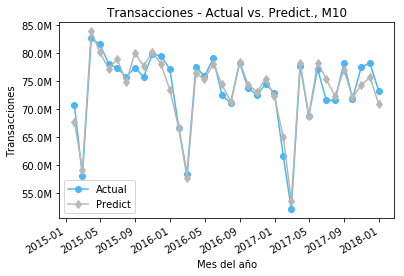

In [76]:
#staticMonthlyPlotting(months_values,yact,ypred_m1, 'M1')
#staticMonthlyPlotting(months_values,yact,ypred_m2, 'M2')
#staticMonthlyPlotting(months_values,yact,ypred_m3, 'M3')
#staticMonthlyPlotting(months_values,yact,ypred_m4, 'M4')
#staticMonthlyPlotting(months_values,yact,ypred_m5, 'M5')
#staticMonthlyPlotting(months_values,yact,ypred_m6, 'M6')
#staticMonthlyPlotting(months_values,yact,ypred_m7, 'M7')
#staticMonthlyPlotting(months_values,yact,ypred_m8, 'M8')
#staticMonthlyPlotting(months_values,yact,ypred_m9, 'M9')
staticMonthlyPlotting(months_values,yact,ypred_m10, 'M10')

### Printing everything to file

In [77]:
complete_ddbb_path = os.path.join(DTPM_TRXDir,'5_RESULTS/1_SYSTEM/0_original/contemporary_complete_db.csv')
complete_db.to_csv(complete_ddbb_path,sep=';',encoding='latin-1')

OLS_Summary_path = os.path.join(DTPM_TRXDir,'5_RESULTS/1_SYSTEM/0_original/contemporary_OLS_Summary.csv')
OLS_Summary.to_csv(OLS_Summary_path, sep=';',encoding='latin-1')

## Closed